# Projeto PLN - Classificação de Sentimentos com Redes Neurais Convolucionais

# Etapa 1: Importação das bibliotecas

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import spacy 
import string
import random
import matplotlib.pyplot as plt
import nltk

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [3]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [4]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

### Dataset de Treino

In [5]:
train_data = pd.read_csv('train.csv', header = None, names = cols, engine = 'python', encoding = 'latin1')

In [6]:
train_data.head()

,sentiment,id,date,query,user,text
0,4,1961154818,Fri May 29 09:04:06 PDT 2009,NO_QUERY,TheMileHighFan,@bareknucks - Great. I'll put something togeth...
1,4,1991641239,Mon Jun 01 07:24:22 PDT 2009,NO_QUERY,ashleymc,@XtrmistModerate I typically try and do that.....
2,4,2068079721,Sun Jun 07 13:27:49 PDT 2009,NO_QUERY,TimmyLovesPaige,@mdozois im doing pretty good. Just hanging ou...
3,0,2285045161,Mon Jun 22 14:38:20 PDT 2009,NO_QUERY,tswei_chen,"back in the FTW, the 817, the land that Trader..."
4,4,2003127315,Tue Jun 02 05:56:07 PDT 2009,NO_QUERY,NathalieCaron,"@KristinaAwesome Good morning! Don't worry, I ..."


- Rótulo 4 se trata de um sentimento positivo
- Rótulo 0 se trata de um sentimento negativo

In [7]:
print("Shape do Dataset de Treino -->",train_data.shape)
print("Rótulos Únicos --> ", tuple(train_data.sentiment.unique()))

Shape do Dataset de Treino --> (100000, 6)
Rótulos Únicos -->  (4, 0)


- Countplot

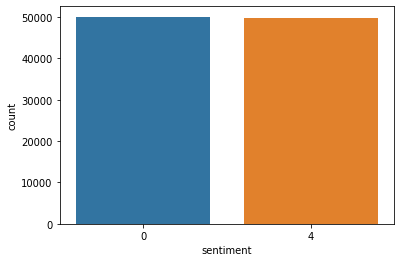

In [8]:
sns.countplot(train_data.sentiment);

### Dataset de Teste

In [9]:
test_data = pd.read_csv("test.csv", header=None,names=cols,engine="python", encoding="latin1")

In [10]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [11]:
print("Shape do Dataset de Teste -->",test_data.shape)
print("Rótulos Únicos --> ", tuple(test_data.sentiment.unique()))

Shape do Dataset de Teste --> (498, 6)
Rótulos Únicos -->  (4, 0, 2)


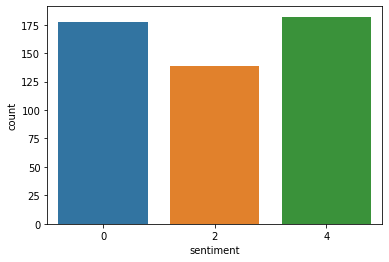

In [12]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [13]:
data = train_data

In [14]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [15]:
data.head()

,sentiment,text
0,4,@bareknucks - Great. I'll put something togeth...
1,4,@XtrmistModerate I typically try and do that.....
2,4,@mdozois im doing pretty good. Just hanging ou...
3,0,"back in the FTW, the 817, the land that Trader..."
4,4,"@KristinaAwesome Good morning! Don't worry, I ..."


In [16]:
X = data.iloc[:, 1].values

In [17]:
X

array(["@bareknucks - Great. I'll put something together and let you know! Go #Nuggets - BTW, I'm the voter in your poll ",
       '@XtrmistModerate I typically try and do that....wish I could stop scheduling at Thursday   That would be nice!',
       '@mdozois im doing pretty good. Just hanging out at universal in the rain with Paige. Lol. Me and mom have been getting along better now. ',
       ...,
       '@mac_in_TO  i never been u r part of the world to,we have a lot of canadians here they have their yachts in marina. you should visit. LOL ',
       "@yelyahwilliams I neeeeeed tickets for ur Sunday show n Houston  sold out! I'll make u a sweet deal for tickets LOL just name it u got it",
       "@guitarscreams me too! i just got the new cd... i'm listening right now. i'm not sure how i feel though yet "],
      dtype=object)

In [18]:
X.shape

(100000,)

In [19]:
y = data.iloc[:, 0].values
y

array([4, 4, 4, ..., 4, 0, 0], dtype=int64)

In [20]:
y.shape

(100000,)

In [21]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4], dtype=int64), array([50101, 49899], dtype=int64))

In [22]:
def clean_tweets(tweet):
  
  # Utilizando beatifulsoup para pegar os textos dos tweets que estão em formato lxml
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  
  # Marcações de perfis
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  
  # Links de imagens
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)

  # Limpar tudo que não seja texto e essas pontuações
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)

  # Limpa alguns caracteres estranhos
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

### Exemplificação da Limpeza

In [23]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [24]:
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

### Carregando vocabulário do spaCy em English

In [31]:
nlp = spacy.load('en_core_web_sm')

### Carregando stopwords do spaCy

In [32]:
stop_words = spacy.lang.en.STOP_WORDS

In [37]:
print(stop_words)
print(len(stop_words))

{'sometimes', 'hundred', 'becomes', 'more', 'before', 'empty', 'beside', 'should', 'twenty', 'none', 'besides', 'thence', 'serious', 'myself', 'ours', 'call', 'few', 'had', 'to', 'through', 'thus', 'ca', 'neither', 'are', 'against', 'there', 'those', 'thereupon', 'forty', 'meanwhile', 'amount', 'was', 'enough', 'behind', "n't", 'seemed', 'give', 'other', 'their', 'though', 'doing', 'must', 'something', 'whereas', 'although', 'himself', 'even', '‘m', 'whom', 'until', 'rather', 'sixty', 'still', 'top', 'however', 'almost', 'themselves', 'go', 'them', 'same', '‘d', 'n‘t', 'all', 'always', 'just', 'whenever', 'across', 'much', 'the', 'someone', 'without', 'bottom', 'us', 'nobody', 'off', 'unless', 'another', 'i', 'along', 'seeming', 'please', 'would', 'often', 'became', 'together', 'whether', 'or', 'wherever', 'mostly', 'has', 'never', 'too', 'twelve', 'again', 'its', 'somewhere', 'two', 'am', 'have', 'beforehand', 'not', 'others', 'both', 'within', 'otherwise', 'up', '’d', 'seems', 'becom

### Carregando pontuações

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
def clean_tweets2(tweet):
  
  # Coloca tudo para minusculo
  tweet = tweet.lower()

  # Transforma o texto em uma váriavel do modelo em inglês do spaCy para conseguir tokenizar
  document = nlp(tweet)

  # Tokenizando
  words = []
  for token in document:
    words.append(token.text)

  # Limpeza para remover stopwords em inglês e também as pontuações
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
# Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D"

In [39]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

### Limpa tudo

In [40]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

### Atribuindo as labels e mudando a categoria de label número 4 (positivo) para o número 1

In [42]:
data_labels = y

In [43]:
data_labels[data_labels == 4] = 1

In [44]:
data_labels

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [45]:
np.unique(data_labels)

array([0, 1], dtype=int64)

### Tokenização

In [46]:
import math
math.pow(2, 16)

65536.0

- O valor 2^16 (65536) é frequentemente escolhido como um valor padrão porque oferece uma boa capacidade de representação de texto para muitos casos de uso comuns.

In [48]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [49]:
tokenizer.vocab_size

65511

In [51]:
ids = tokenizer.encode('i am happy')
ids

[573, 18428, 362]

In [52]:
text = tokenizer.decode(ids)
text

'i am happy'

In [53]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

### Padding ( Completar os vetores pra ficar do mesmo tamanho)

In [55]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

61

In [56]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [57]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1     2  3299    91   242 10771   158   157     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[920   5 295 715   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[    1 24632    52     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[   4

### Divisão da base de dados em treinamento e teste



In [58]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [60]:
train_inputs.shape

(70000, 61)

In [61]:
train_labels.shape

(70000,)

In [62]:
test_inputs.shape

(30000, 61)

In [63]:
test_labels.shape

(30000,)

# Etapa 3: Construção do modelo

In [64]:
class DCNN(tf.keras.Model):


  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    # Camadas de Embeddings, vulgo camada de entrada
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    # Primeira camada de Convolução para os bigramas, usando o kernel_size = 2 por ser de bigramas, padding = 'same' por se tratar de vetores do mesmo tamanho
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    # Camada de redimensionamento que puxam as caracteristicas mais importantes
    self.pool = layers.GlobalMaxPool1D()

    # Primeira camada Densa com a quantidade de "neuronios" que é parametrizada no ffn_units
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    
    # Camada para dropar alguns "neuronios" para evitar overfitting no modelo
    self.dropout = layers.Dropout(rate = dropout_rate)

    # Ultima camda Densa, que vai ser camada de saída do modelo 
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  # Chamando as funções que foram criadas na Rede Neural
  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [65]:
vocab_size = tokenizer.vocab_size
vocab_size

65511

In [66]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [67]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [68]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [69]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [71]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
985/985 [==============================] - 292s 295ms/step - loss: 0.5250 - accuracy: 0.7338 - val_loss: 0.4961 - val_accuracy: 0.7491
Epoch 2/5
985/985 [==============================] - 292s 296ms/step - loss: 0.3344 - accuracy: 0.8555 - val_loss: 0.5762 - val_accuracy: 0.7426
Epoch 3/5
985/985 [==============================] - 287s 291ms/step - loss: 0.1404 - accuracy: 0.9446 - val_loss: 0.8165 - val_accuracy: 0.7237
Epoch 4/5
985/985 [==============================] - 294s 299ms/step - loss: 0.0640 - accuracy: 0.9739 - val_loss: 1.0260 - val_accuracy: 0.7061
Epoch 5/5
985/985 [==============================] - 291s 296ms/step - loss: 0.0409 - accuracy: 0.9830 - val_loss: 1.4170 - val_accuracy: 0.7284


'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [72]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

469/469 [==============================] - 4s 8ms/step - loss: 1.4006 - accuracy: 0.7262
[1.4005699157714844, 0.7262333035469055]


In [73]:
y_pred_test = Dcnn.predict(test_inputs)

938/938 [==============================] - 4s 4ms/step


In [74]:
y_pred_test

array([[0.11843121],
       [0.898648  ],
       [0.9999943 ],
       ...,
       [0.00238468],
       [0.9999163 ],
       [0.9999999 ]], dtype=float32)

In [75]:
y_pred_test = (y_pred_test > 0.5)

In [76]:
y_pred_test

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [77]:
test_labels

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[10980,  4050],
       [ 4163, 10807]], dtype=int64)

In [89]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     15030
           1       0.73      0.72      0.72     14970

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000



<AxesSubplot:>

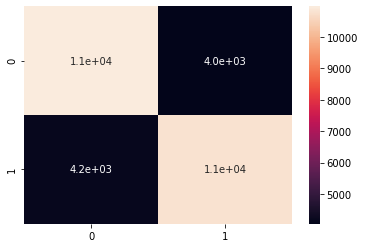

In [79]:
sns.heatmap(cm, annot=True)

In [80]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

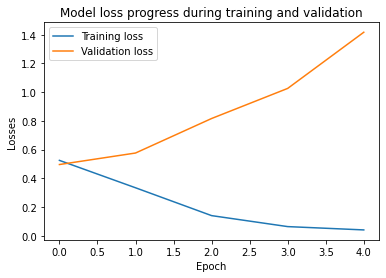

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

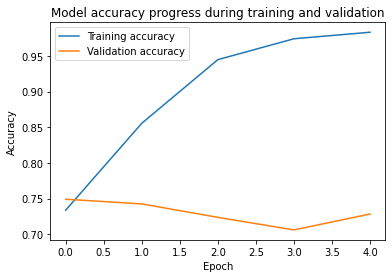

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [107]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[573, 70, 3643]

In [108]:
Dcnn(np.array([text]), training=False).numpy() > 0.5

array([[False]])